1. Project Description
This part is to load the dataset and inspect its structure:
##Examine the data for any missing values or anomalies.##
##Check the distribution of the target categories.##

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bopang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/jc/ccl73yps6zz661hhx9y7zlg40000gn/T/ipykernel_2229/2816172782.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_distribution.index, y=category_distribution.values, palette='viridis')


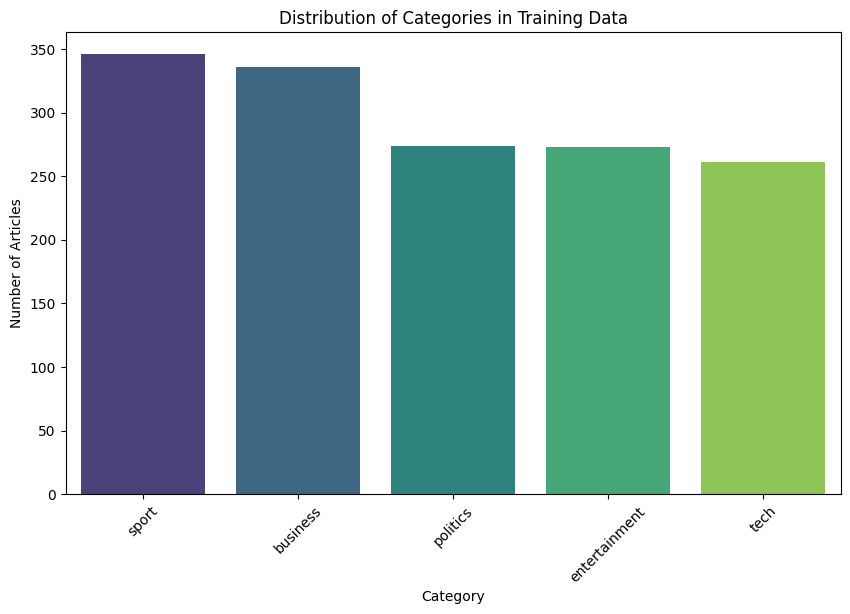

ArticleId    0
Text         0
Category     0
dtype: int64

In [51]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the datasets
train_data = pd.read_csv('data/BBC News Train.csv')
test_data = pd.read_csv('data/BBC News Test.csv')

# Display the first few rows of the training dataset
train_data.head()

# Check for missing values in the training data
missing_values = train_data.isnull().sum()

# Distribution of categories in the training data
category_distribution = train_data['Category'].value_counts()

# Plotting the distribution of categories
plt.figure(figsize=(10, 6))
sns.barplot(x=category_distribution.index, y=category_distribution.values, palette='viridis')
plt.title('Distribution of Categories in Training Data')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

# Check for missing values
missing_values



2. Data cleaning and text processing.

In [52]:
# Data preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the 'Text' column
train_data['Text'] = train_data['Text'].apply(preprocess_text)
test_data['Text'] = test_data['Text'].apply(preprocess_text)

train_data.head()


,ArticleId,Text,Category
0,1833,worldcom exboss launches defence lawyers defen...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens maj...,business
3,1976,lifestyle governs mobile choice faster better ...,tech
4,917,enron bosses 168m payout eighteen former enron...,business


3. Use TF-IDF for embedding, and perform the conversion.

/var/folders/jc/ccl73yps6zz661hhx9y7zlg40000gn/T/ipykernel_2229/3578861968.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_scores.values, y=tfidf_scores.index, palette='viridis')


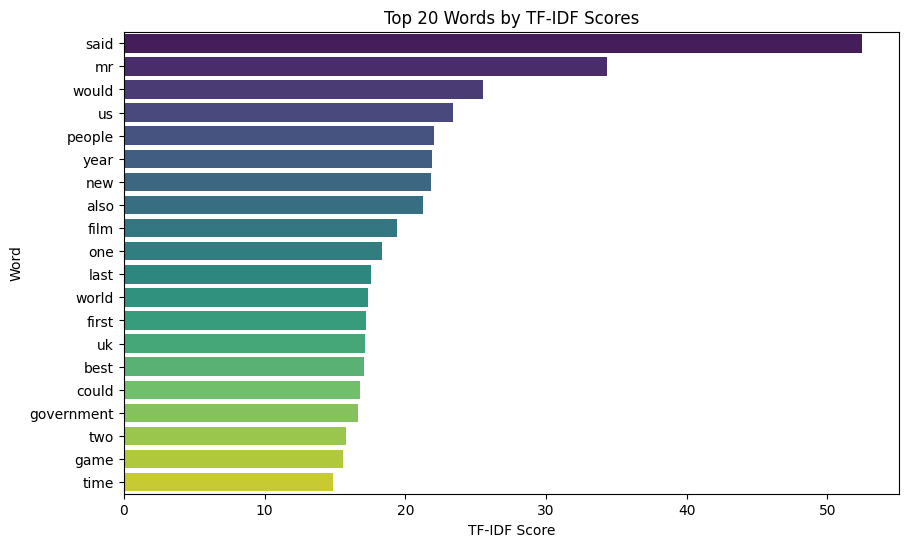

In [53]:

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data['Text'], train_data['Category'], test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the validation data
X_val_tfidf = tfidf.transform(X_val)

# Transform the test data
X_test_tfidf = tfidf.transform(test_data['Text'])

X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Display the first few rows of the TF-IDF features
X_train_tfidf_df.head()

tfidf_scores = X_train_tfidf_df.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_scores.values, y=tfidf_scores.index, palette='viridis')
plt.title('Top 20 Words by TF-IDF Scores')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.show()


3. Fit NMF to the training data.
	Transform the training and test data using the fitted NMF model. Train a classifier using the transformed training data.
	Evaluate the model on the test data.

In [54]:
### Matrix Factorization Model
# Initialize and fit the NMF model
nmf = NMF(n_components=20, random_state=42)
W_train = nmf.fit_transform(X_train_tfidf)
H = nmf.components_

# Transform the validation data using the fitted NMF model
W_val = nmf.transform(X_val_tfidf)

# Transform the test data using the fitted NMF model
W_test = nmf.transform(X_test_tfidf)

# Train a classifier using the transformed training data
clf_nmf = LogisticRegression(random_state=42, max_iter=1000)
clf_nmf.fit(W_train, y_train)

# Predict on the validation data
y_pred_nmf = clf_nmf.predict(W_val)

# Evaluate the NMF model
print("NMF Model Classification Report:")
print(classification_report(y_val, y_pred_nmf))
print(f"NMF Model Accuracy: {accuracy_score(y_val, y_pred_nmf):.4f}")

### Supervised Learning Model
# Train a Logistic Regression model on the original TF-IDF features


NMF Model Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.97      0.96        75
entertainment       0.98      0.93      0.96        46
     politics       0.93      0.91      0.92        56
        sport       0.91      1.00      0.95        63
         tech       0.96      0.88      0.92        58

     accuracy                           0.94       298
    macro avg       0.95      0.94      0.94       298
 weighted avg       0.94      0.94      0.94       298

NMF Model Accuracy: 0.9430


4. Supervised Learning Model Adapted

In [55]:
clf_supervised = LogisticRegression(random_state=42, max_iter=1000)
clf_supervised.fit(X_train_tfidf, y_train)

# Predict on the validation data
y_pred_supervised = clf_supervised.predict(X_val_tfidf)

# Evaluate the supervised model
print("Supervised Model Classification Report:")
print(classification_report(y_val, y_pred_supervised))
print(f"Supervised Model Accuracy: {accuracy_score(y_val, y_pred_supervised):.4f}")



Supervised Model Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.97      0.96        75
entertainment       0.98      0.96      0.97        46
     politics       0.93      0.95      0.94        56
        sport       0.98      1.00      0.99        63
         tech       0.98      0.93      0.96        58

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298

Supervised Model Accuracy: 0.9631


5. Visualize and Compare the Results

/var/folders/jc/ccl73yps6zz661hhx9y7zlg40000gn/T/ipykernel_2229/3743808273.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


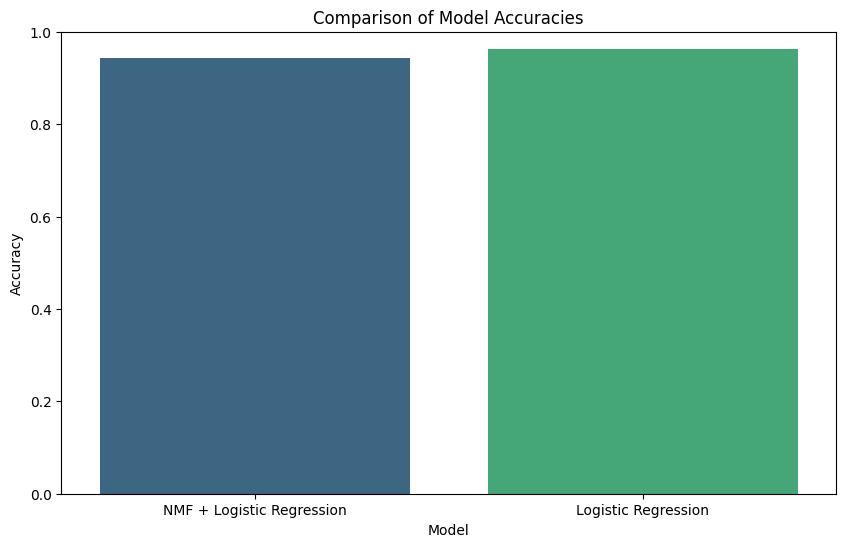

   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


In [56]:
### Comparison of Accuracies
# Calculate the accuracies of both models
accuracy_nmf = accuracy_score(y_val, y_pred_nmf)
accuracy_supervised = accuracy_score(y_val, y_pred_supervised)

# Create a bar plot to compare accuracies
models = ['NMF + Logistic Regression', 'Logistic Regression']
accuracies = [accuracy_nmf, accuracy_supervised]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

### Predict Categories for Test Data
# Predict on the test data using the NMF model
y_test_pred_nmf = clf_nmf.predict(W_test)

# Create a DataFrame to display the results
test_results = test_data.copy()
test_results['Category'] = y_test_pred_nmf

# Keep only 'ArticleId' and 'Predicted_Category' columns
test_results = test_results[['ArticleId', 'Category']]

# Display the first few rows of the test results
print(test_results.head())

# Save the test results to a CSV file
test_results.to_csv('test_results.csv', index=False)

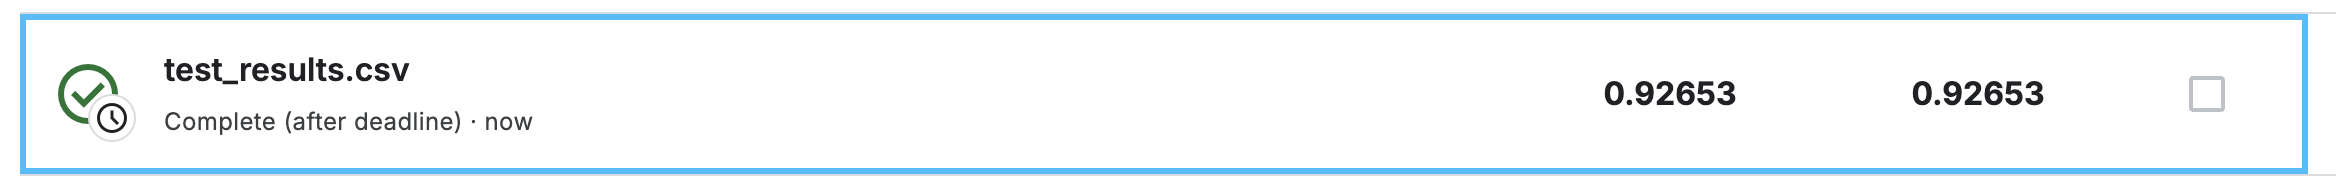

In [2]:
from IPython.display import Image
Image(filename='result-from-kaggle.png') 